<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/EDA/PimaKaggle/Pima_indians_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima indians diabetes kaggle dataset

### import libs

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import boxcox

In [21]:
%matplotlib inline

### download dataset

In [6]:
%%capture
!wget -O pima.csv https://raw.githubusercontent.com/Dimildizio/DArc_course/main/EDA/PimaKaggle/pima-indians-diabetes.csv

In [251]:
columns = ['pregnancies','glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'BMI', 'Pedigree', 'Age', 'Result']
data = pd.read_csv('pima.csv', names = columns)
data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check the size of the dataset

In [252]:
data.shape

(768, 9)

### Check for NaNs and data types

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int64  
 1   glucose         768 non-null    int64  
 2   blood_pressure  768 non-null    int64  
 3   skin_thickness  768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   BMI             768 non-null    float64
 6   Pedigree        768 non-null    float64
 7   Age             768 non-null    int64  
 8   Result          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Convert float\int 64 to 32 for faster operatinos

In [254]:
for col in data.columns:
  if data[col].dtype == 'float64':
    data[col] = data[col].astype('float32')

  elif data[col].dtype == 'int64':
    data[col] = data[col].astype('int32')

### Get statistics by columns

In [255]:
pd.set_option('display.precision', 3)
data.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.373,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


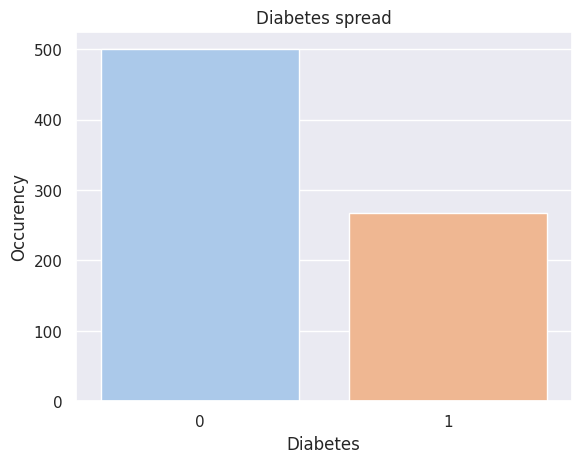

In [256]:
sns.set(style="darkgrid")
sns.set_palette('pastel')
sns.countplot(data=data, x='Result')

plt.title('Diabetes spread')
plt.xlabel('Diabetes')
plt.ylabel('Occurency')
plt.show()

Not ideal distibution, so we'll have to address this issue later, possibly by adding sythetic rows.

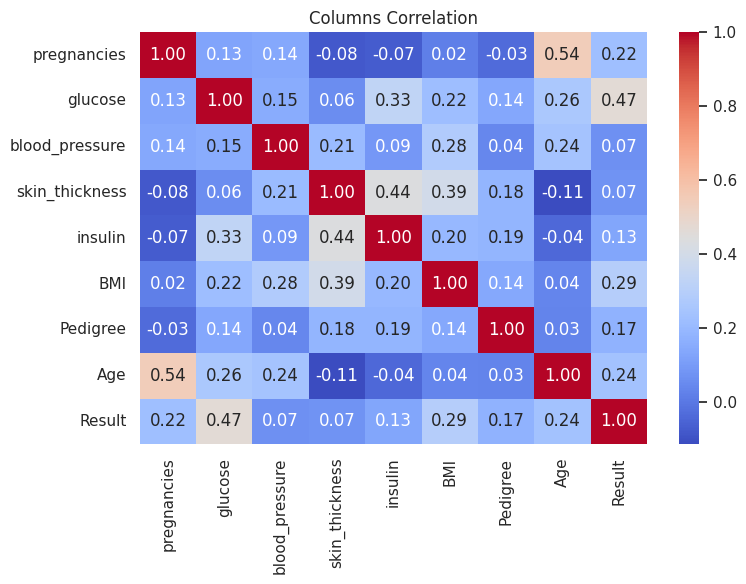

In [257]:
plt.figure(figsize=(8,6))

corr_matrix = data.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title('Columns Correlation')
plt.tight_layout()

Clearly a very "combed" dataset. No NaNs, no high correlation

### Check for skewness

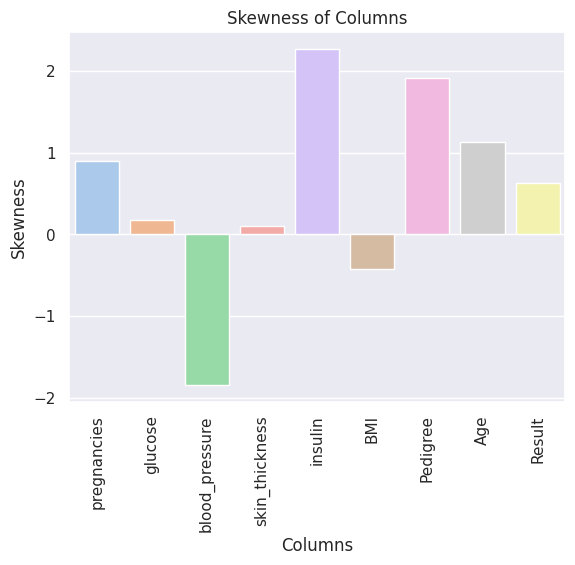

In [258]:
skewness = data.skew()
sns.barplot(x=skewness.index, y=skewness)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of Columns')
plt.show()

### Plot distribution and density curve

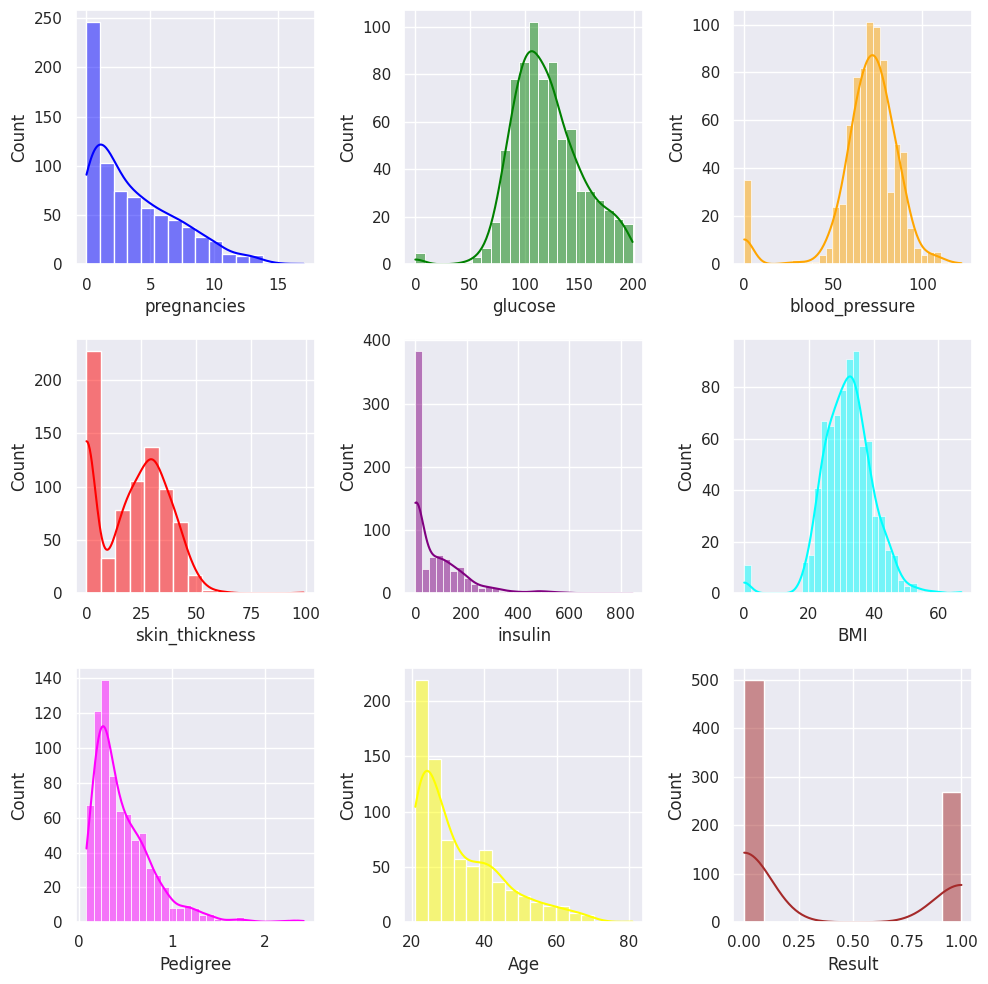

In [259]:
n = 3
fig, axes = plt.subplots(n, n, figsize=(10,10))
colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'brown']

for num, column in enumerate(data.columns):
  row = num // n
  col = num % n
  ax = axes[row, col]
  sns.histplot(data[column], kde=True, color=colors[num], ax=ax)
plt.tight_layout()
plt.show()

Looks like we got some outliers as well as some BMI, skin_thickness, insulin, blood_pressure and glucose values 0 which is not possible.

### Check which rows (suspicious) got 0 as values

In [261]:
data[(data['insulin']==0) | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_pressure']==0) | (data['glucose']==0)]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


It also seems that for the half of the dataset the parameters haven't been taken and empty values have been filled with 0.
Also if we remove all cols but insulin, it will leave us with the same 374 out of 376 with missing data (extra ones go for glucose and BMI each).

One of the options could be taking mean, median, mode or using linear regression on the dataset with nonzero parameters.

### Check for outliers

There is no reason in finding IQR since there are too many zeros, o we'll try to find outliers manually by looking at the hist graph.

In [262]:
data[(data['insulin'] > 500) | (data['skin_thickness']>70) | (data['Pedigree'] > 2)]# | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_presure']==0) | (data['glucose']==0)]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
4,0,137,40,35,168,43.1,2.288,33,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
228,4,197,70,39,744,36.7,2.329,31,0
247,0,165,90,33,680,52.3,0.427,23,0
286,5,155,84,44,545,38.7,0.619,34,0
370,3,173,82,48,465,38.4,2.137,25,1
409,1,172,68,49,579,42.4,0.702,28,1
445,0,180,78,63,14,59.4,2.420,25,1
579,2,197,70,99,0,34.7,0.575,62,1


Just 2% of the dataset so we could safely remove these rows, but it seems that most of those abnormal values result in positive diabetes so the anomalies in data could be not the problem in statistics but a symptom of a disease.

Which means we shouldn't remove them.

## Address skewness

As pedigree, age, and pregnancies are the only values which don't have zeros or we're ok with that, we'll work with them for now.

#### Let's prepare some code to see the best transformations

In [263]:
transformed_data = data.copy()

In [264]:
def bxcx(df):
  result, _ = boxcox(df+1) #we add one in case of zero values
  return result

In [265]:
def plot_transforms(data, name):
  operations = [np.sqrt, np.cbrt, np.log, np.log1p]
  opernames = ['square root', 'cube root', 'log', 'log1p', 'boxcox']
  colors = ['magenta', 'blue','orange','indigo', 'red']
  fig, axes = plt.subplots(1, 5, figsize=(12,2))
  fig.suptitle(name)

  def plot_in_subplots(result, num):
    sns.histplot(result, kde=True, color = colors[num], ax=axes[num])
    axes[num].set_xlabel(opernames[num])
    axes[num].set_ylabel('')

  for num in range(4):
    result = data[name].apply(lambda x: operations[num](x))
    plot_in_subplots(result, num)

  result = bxcx(data[name])
  plot_in_subplots(result, 4)

#### Pedigree

Since there are many values between 1 and 0, we were going to apply np.log1p (adding 1), but taking cube root provides better looking bell distribution

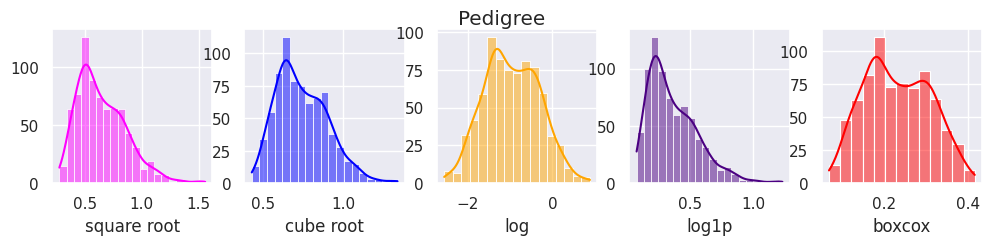

In [266]:
plot_transforms(transformed_data, 'Pedigree')

looks like boxcox+1 perfroms better

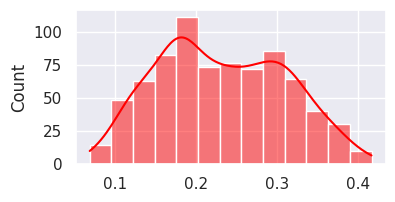

In [267]:
pedigree = data['Pedigree'].copy()
pedigree = bxcx(pedigree)
plt.figure(figsize = (4,2))
sns.histplot(pedigree, kde=True, color = 'red')
transformed_data['Pedigree'] = pedigree

#### Age

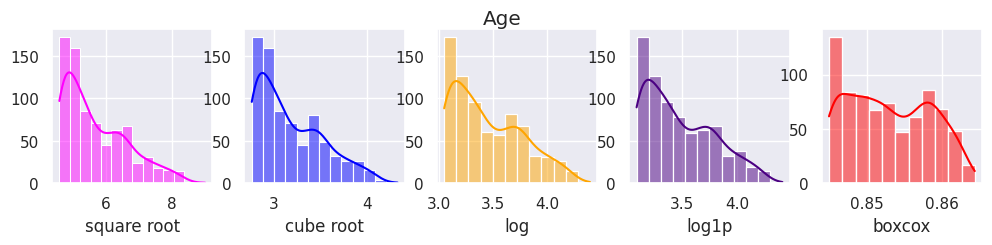

In [268]:
plot_transforms(transformed_data, 'Age')

Not much we can do here since the data is very skewed itself, my choice falls on boxcox

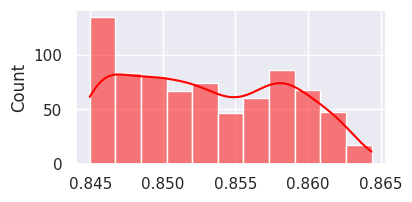

In [269]:
age = data['Age'].copy()
age = bxcx(age)
plt.figure(figsize = (4,2))
sns.histplot(age, kde=True, color = 'red')
transformed_data['Age'] = age

#### Pregnacies

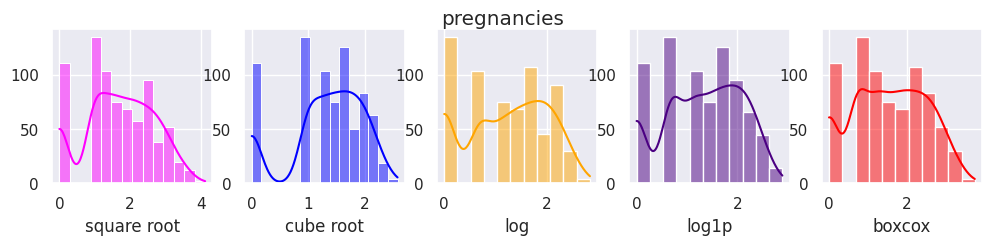

In [270]:
plot_transforms(transformed_data, 'pregnancies')

Not much difference seen here. Let's choose log1p (def not log since we got zeros) for once

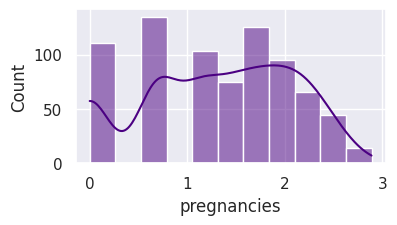

In [283]:
preg = data['pregnancies'].copy()
preg = preg.apply(lambda x: np.log1p(x))
plt.figure(figsize = (4,2))
sns.histplot(preg, kde=True, color='indigo')
transformed_data['pregnacies'] = preg

## Fill zero values

In [272]:
zero_df = pd.DataFrame({'Zeros':data.eq(0).sum()})
zero_df

,Zeros
pregnancies,111
glucose,5
blood_pressure,35
skin_thickness,227
insulin,374
BMI,11
Pedigree,0
Age,0
Result,500


### Glucose

In [273]:
transformed_data[transformed_data['glucose']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
75,1,0,48,20,0,24.7,0.113,0.846,0
182,1,0,74,20,23,27.7,0.198,0.845,0
342,1,0,68,35,0,32.0,0.232,0.846,0
349,5,0,80,32,0,41.0,0.217,0.857,1
502,6,0,68,41,0,39.0,0.314,0.858,1


since we got just 5 zero values we can simply fill 0 glucose with mean.

In [284]:
gluc_df = transformed_data.copy()
gluc_df['glucose'].replace(0, gluc_df['glucose'].mean(), inplace=True)

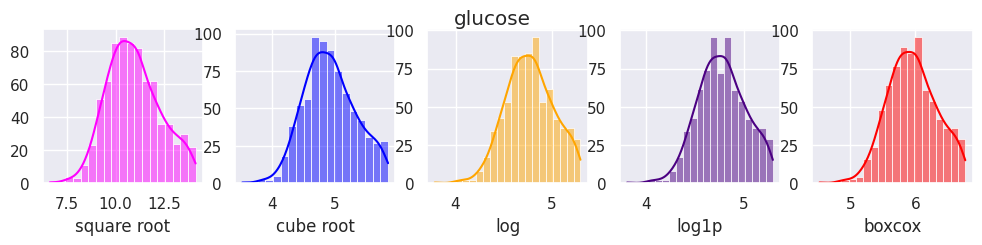

In [285]:
plot_transforms(gluc_df, 'glucose')

Square root transformation looks nice

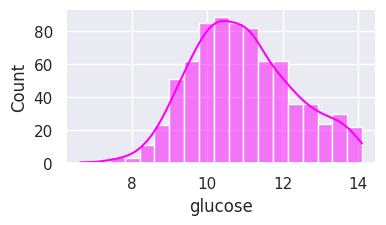

In [287]:
gluc = gluc_df['glucose'].copy()
gluc = gluc.apply(lambda x: np.sqrt(x))
plt.figure(figsize = (4,2))
sns.histplot(gluc, kde=True, color='magenta')
gluc_df['glucose'] = gluc

### BMI

In [275]:
gluc_df[gluc_df['BMI']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result
9,8,125.0,96,0,0,0.0,0.167,0.861,1
49,7,105.0,0,0,0,0.0,0.200,0.848,0
60,2,84.0,0,0,0,0.0,0.200,0.845,0
81,2,74.0,0,0,0,0.0,0.087,0.846,0
145,0,102.0,75,23,0,0.0,0.284,0.845,0
371,0,118.0,64,23,89,0.0,0.398,0.845,0
426,0,94.0,0,0,0,0.0,0.178,0.849,0
494,3,80.0,0,0,0,0.0,0.135,0.846,0
522,6,114.0,0,0,0,0.0,0.143,0.850,0
684,5,136.0,82,0,0,0.0,0.298,0.863,0


Same here. ~1.5% of all dataset could be filled with means with no issues

In [290]:
bmi_df = gluc_df.copy()
bmi_df['BMI'].replace(0, bmi_df['BMI'].mean(), inplace=True)
bmi_df[bmi_df['BMI']<=0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result,pregnacies


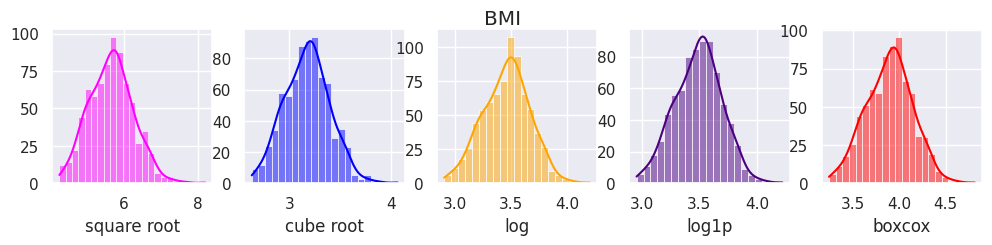

In [291]:
plot_transforms(bmi_df, 'BMI')

Anything look nice. Let's do log

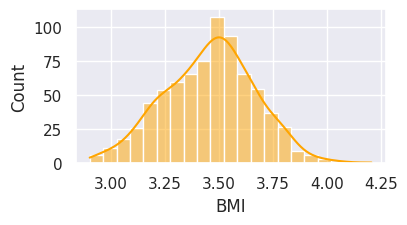

In [293]:
bmi = bmi_df['BMI'].copy()
bmi = bmi.apply(lambda x: np.log(x))
plt.figure(figsize = (4,2))
sns.histplot(bmi, kde=True, color='orange')
bmi_df['BMI'] = bmi

### Blood pressure

blood pressure has 35 zero values and we assume that all the test participants were alive. 35 of 768 is coming close to 5% which I'd select as a limit for filling with mean, but 4.5 is lower than 5, so we'll do the same operation here as well.

In [295]:
bp_df = bmi_df.copy()
bp_df['blood_pressure'].replace(0, bp_df['blood_pressure'].mean(), inplace=True)
bp_df[bp_df['blood_pressure']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,Pedigree,Age,Result,pregnacies


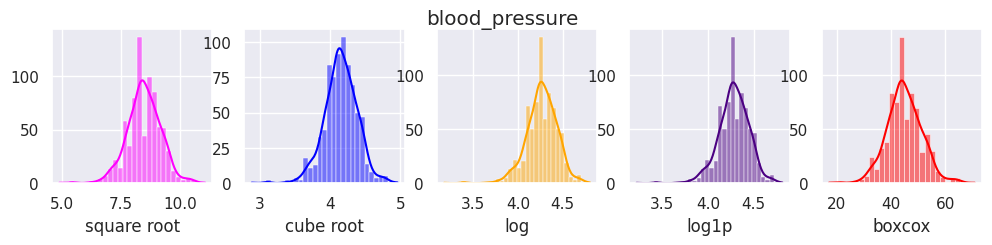

In [296]:
plot_transforms(bp_df, 'blood_pressure')

Looks like cube root is a winner, smoothing outliers

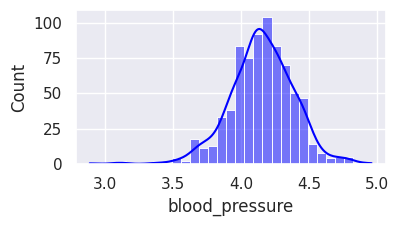

In [301]:
bp = bp_df['blood_pressure'].copy()
bp = bp.apply(lambda x: np.cbrt(x))
plt.figure(figsize = (4,2))
sns.histplot(bp, kde=True, color='blue')
bp_df['blood_pressure'] = bp